In [1]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, string, math, os
from typing import List, Dict
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sentence_transformers import SentenceTransformer
from tokenizers import ByteLevelBPETokenizer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import kagglehub

In [2]:
# import data

# download latest version from kaggle
path = kagglehub.dataset_download("priyangshumukherjee/mental-health-text-classification-dataset")

# # lists all files resulting from kaggle download
# file = os.listdir(path)
# print(file)

# going to make model off of the larger set
data = pd.read_csv(f"{path}/mental_heath_unbanlanced.csv")

Using Colab cache for faster access to the 'mental-health-text-classification-dataset' dataset.
['mental_health_combined_test.csv', 'mental_heath_unbanlanced.csv', 'mental_heath_feature_engineered.csv']


# Functions and Model

In [3]:
# using bpe for vectorization
def bpe_encode(text, max_len):
    token = bpe.encode(text).ids[:max_len]
    padded = [0] * (max_len - len(token))
    results = token + padded
    return results

In [4]:
# my own neural network model

class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, dropout):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.l1 = nn.Linear(embed_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.l3 = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.l4 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.l5 = nn.Linear(hidden_dim, hidden_dim)
        self.l6 = nn.Linear(hidden_dim, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x).mean(dim=1)

        x = self.dropout(self.relu(self.l1(x)))
        x = self.dropout(self.relu(self.l2(x)))
        x = self.dropout(self.relu(self.l3(x)))
        x = self.dropout(self.relu(self.l4(x)))
        x = self.dropout(self.relu(self.l5(x)))
        x = self.l6(x)

        return x

# Prep for Training



In [5]:
# define variables and enact functions
bpe = ByteLevelBPETokenizer()
bpe.train_from_iterator(data['text'].tolist(), vocab_size=2000, min_frequency=2)

# convert status to numbers
status_map = {
    'Suicidal': 0,
    'Depression': 1,
    'Anxiety': 2,
    'Normal': 3
}

# apply mapping
x = data['text']
y = data['status'].map(status_map).values

# split the data
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# convert split data into tensors
x_train_torch = torch.tensor([bpe_encode(t, 100) for t in x_train], dtype=torch.long)
x_test_torch  = torch.tensor([bpe_encode(t, 100) for t in x_test],  dtype=torch.long)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch  = torch.tensor(y_test,  dtype=torch.long)

In [6]:
# Define variables: loss function and optimizer
my_model = SentimentModel(vocab_size= bpe.get_vocab_size(), embed_dim= 64, hidden_dim= 128, num_classes= 4, dropout = 0.5)

criterion = nn.CrossEntropyLoss()  # this optimizer best for multiple options of answer, not binary
optimizer = optim.Adam(my_model.parameters(), lr=0.001)  # Adam better for sentiment analysis

In [7]:
# training in batches instead of all at once

num_epochs = 200
model_loss_history = []

data_pairs = TensorDataset(x_train_torch, y_train_torch)
data_loader = DataLoader(data_pairs, batch_size=32, shuffle=True)

for epoch in range(num_epochs):
    my_model.train()
    epoch_loss = 0

    # this part is the same as previous, just using smaller batches
    for x_batch, y_batch in data_loader:
        predictions = my_model(x_batch)
        loss = criterion(predictions, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(data_loader)
    model_loss_history.append(avg_loss)

    if (epoch + 1) % 10 == 0:
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 10/200, Loss: 0.5043
Epoch 20/200, Loss: 0.4352
Epoch 30/200, Loss: 0.3901
Epoch 40/200, Loss: 0.3601
Epoch 50/200, Loss: 0.3413
Epoch 60/200, Loss: 0.3259
Epoch 70/200, Loss: 0.3105
Epoch 80/200, Loss: 0.2965
Epoch 90/200, Loss: 0.2900
Epoch 100/200, Loss: 0.2783
Epoch 110/200, Loss: 0.2768
Epoch 120/200, Loss: 0.2644
Epoch 130/200, Loss: 0.2611
Epoch 140/200, Loss: 0.2543
Epoch 150/200, Loss: 0.2433
Epoch 160/200, Loss: 0.2369
Epoch 170/200, Loss: 0.2398
Epoch 180/200, Loss: 0.2310
Epoch 190/200, Loss: 0.2196
Epoch 200/200, Loss: 0.2259


In [19]:
# Evaluate model on test set
my_model.eval()
with torch.no_grad():
    test_predictions = my_model(x_test_torch)
    predicted_classes = test_predictions.argmax(dim=1)
    accuracy = (predicted_classes == y_test_torch).float().mean()

print(f"My Model Test Accuracy: {accuracy.item() * 100:.2f}%")

print('\n', classification_report( y_test_torch.cpu().numpy(), predicted_classes.cpu().numpy(), target_names=['Suicidal', 'Depression', 'Anxiety', 'Normal']))

My Model Test Accuracy: 76.91%

               precision    recall  f1-score   support

    Suicidal       0.65      0.68      0.66      2243
  Depression       0.70      0.67      0.68      2901
     Anxiety       0.77      0.76      0.77      1101
      Normal       0.90      0.91      0.90      3678

    accuracy                           0.77      9923
   macro avg       0.75      0.75      0.75      9923
weighted avg       0.77      0.77      0.77      9923



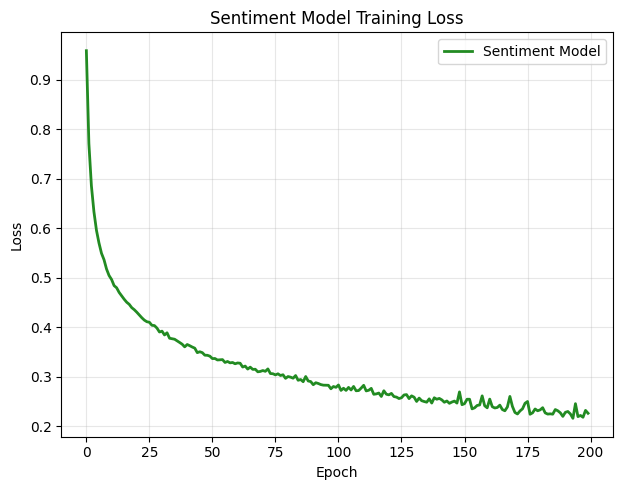

In [12]:
# graph Sentiment model loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(model_loss_history, label='Sentiment Model', color='forestgreen', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Sentiment Model Training Loss')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
def predict_sentiment(text: str):
    test_word_ids = bpe_encode(text, 100)
    tensor = torch.tensor([test_word_ids], dtype=torch.long)  # (1, 100)

    my_model.eval()
    with torch.no_grad():
        logits = my_model(tensor)
        probs = torch.softmax(logits, dim=1)[0]
        pred = probs.argmax().item()

    return pred, probs.numpy()

# Test status
test_status = [
    'I dont think life is worth living anymore',
    'What if she is mad at me? I dont know what to do help me! ',
    'Things have been pretty alright, stressed but not horrible'
]

print('Testing Status:\n')
for review in test_status:
    pred, prob = predict_sentiment(review)
    if pred == 0:
        status = 'Suicidal'
    elif pred == 1:
        status = 'Depression'
    elif pred == 2:
        status = 'Anxiety'
    elif pred == 3:
        status = 'Normal'
    conf = prob[pred] * 100
    print(f'{review}')
    print(f'  → {status} ({conf:.1f}%)\n')

Testing Status:

I dont think life is worth living anymore
  → Suicidal (92.3%)

What if she is mad at me? I dont know what to do help me! 
  → Suicidal (78.5%)

Things have been pretty alright, stressed but not horrible
  → Normal (92.1%)



In [16]:
# more test samples for fun

# Test status
test_status_2 = [
    'I have a lot of homework, Ive been so busy but Im learning a lot',
    'my dad hurt my feelings a lot as a kid, and made me feel worthless',
    'is a world without you worth living in?',
    'what do I do? I am really overwhelmed, what if everyone judges me?',
    'help... im not sure what to do',
    'does my boyfriend hate me? I think he likes other people more than me',
    'my roommate and I had a fight, she never cleans dishes and it frustrates me',
]

print('Testing Status:\n')
for review in test_status_2:
    pred, prob = predict_sentiment(review)
    if pred == 0:
        status = 'Suicidal'
    elif pred == 1:
        status = 'Depression'
    elif pred == 2:
        status = 'Anxiety'
    elif pred == 3:
        status = 'Normal'
    conf = prob[pred] * 100
    print(f'{review}')
    print(f'  → {status} ({conf:.1f}%)\n')

Testing Status:

I have a lot of homework, Ive been so busy but Im learning a lot
  → Normal (100.0%)

my dad hurt my feelings a lot as a kid, and made me feel worthless
  → Depression (76.3%)

is a world without you worth living in?
  → Suicidal (58.2%)

what do I do? I am really overwhelmed, what if everyone judges me?
  → Suicidal (79.8%)

help... im not sure what to do
  → Normal (71.4%)

does my boyfriend hate me? I think he likes other people more than me
  → Suicidal (79.1%)

my roommate and I had a fight, she never cleans dishes and it frustrates me
  → Normal (92.8%)



# Results from Lab 1 to Compare:

```
               precision    recall  f1-score   support

    Suicidal       0.68      0.46      0.55      2243
  Depression       0.53      0.79      0.63      2901
     Anxiety       0.82      0.31      0.45      1101
      Normal       0.81      0.81      0.81      3678

    accuracy                           0.67      9923
   macro avg       0.71      0.59      0.61      9923
weighted avg       0.70      0.67      0.66      9923
```

```
Testing Status:

I dont think life is worth living anymore
  → Suicidal (61.4%)

What if she is mad at me? I dont know what to do help me!
  → Normal (34.3%)

Things have been pretty alright, stressed but not horrible
  → Depression (48.5%)


```


# Reflection:

- I am happy with how it turned out, the new sentiment model performed better than lab 1's model at 76.91% accuracy and performing more accurate on the examples given to both.

- The new sentiment model gives analysis with more certainty and consistency, lab 1 model gave low scores of confidence for correct answers while this sentiment model gave higher precentages or confidence.

- Training was challenging, had to decrease batch size so it wouldn't get stuck, but it did start to get noisy towards the end of training.

- From the specific text examples I gave to specify, it did not predict anxiety how I expected, mislabeling things as suicidal where I would have thought it would be anxiety. That could be a semantic misunderstanding of my presumption of anxiety, or because the corpus of anxiety data is much smaller than the other 3 statuses.  

- Doing this exercises helped me solidify my understanding of neural networks and how each piece of the puzzle connect to each other. While it is smaller scale, the changes I implemented did show improvement in it's performance.

- Using a heavier model such as GPT or BERT would probably give more accurate results, but this was a good experiment to see how some spot changes improved the accuracy overall.

- In fiture I would want to try to add more data to this through reddit scraping or another dataset. I would also want to attempt to find other mental health issues such as OCD, mania, BPD, etc. More thorough data would help me expand the potential of my model, as well as inhancements to my model itself.